In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [75]:
import os
import math
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
import timeit
import time
import zipfile
import urllib.request

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

!pip3 install kaggle


In [53]:
#Download requiered datasets from different data sources
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list
! kaggle datasets download -d phylake1337/fire-dataset
# from kaggle.api.kaggle_api_extended import KaggleApi
# api = KaggleApi()
# api.authenticate()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-23 00:53:41          83256  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          14271  
josehenriqueroveda/fertilizers-by-product-fao               Fertilizers by Product FAO                            1MB  2020-06-16 13:01:07            199  
rohan0301/unsupervised-learning-on-country-data             Unsupervised Learning on Country Data                 5KB  2020-06-17 07:45:45            297  
made

In [58]:
#Download and import test data
def create_folder(path, folder_name):
  if ('images' not in os.listdir(os.getcwd())):
    os.mkdir(path)
  if (folder_name not in os.listdir(path)):
    os.mkdir(path + '/' + folder_name)

    

create_folder(os.getcwd()+'/images', 'train')
create_folder(os.getcwd()+'/images', 'test')
create_folder(os.getcwd()+'/images', 'val')

create_folder(os.getcwd()+'/images/train', 'fire')
create_folder(os.getcwd()+'/images/train', 'smoke')
create_folder(os.getcwd()+'/images/train', 'neutral')

create_folder(os.getcwd()+'/images/test', 'fire')
create_folder(os.getcwd()+'/images/test', 'smoke')
create_folder(os.getcwd()+'/images/test', 'neutral')

create_folder(os.getcwd()+'/images/val', 'fire')
create_folder(os.getcwd()+'/images/val', 'smoke')
create_folder(os.getcwd()+'/images/val', 'neutral')

train_images_path = os.getcwd() + '/images/train'
test_images_path = os.getcwd() + '/images/val'
create_folder(os.getcwd(),'resources')



postive_cases = 'fire'
negative_cases = 'non_fire'


In [23]:
# !wget --quiet -O /content/test_data_keras.zip https://github.com/DeepQuestAI/Fire-Smoke-Dataset/releases/download/v1/FIRE-SMOKE-DATASET.zip
# !wget --quiet -O /content/fire_dataset_kaggle.zip https://www.kaggle.com/phylake1337/fire-dataset/download
urllib.request.urlretrieve('https://www.kaggle.com/phylake1337/fire-dataset/download')

('/tmp/tmpcxlxkg21', <http.client.HTTPMessage at 0x7f0ce8c8b8d0>)

In [55]:
with zipfile.ZipFile('test_data_keras.zip', 'r') as zip_ref:
    zip_ref.extractall('resources')
with zipfile.ZipFile('fire-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('resources')    
    

In [73]:
#Move files to the final folder
fire_dataset_fire= 'resources/fire_dataset/fire_images'
fire_dataset_neutral = 'resources/fire_dataset/non_fire_images'
fire_dataset2_path = 'resources/FIRE-SMOKE-DATASET/Train/Fire'

train_fire_data = 'images/train/fire'
train_neutral_data = 'images/train/neutral'
train_smoke_data = 'images/train/smoke'

test_fire_data = 'images/test/fire'
test_neutral_data = 'images/test/neutral'
test_smoke_data = 'images/test/smoke'

positive_samples = os.listdir(fire_dataset_fire)
neutral_samples = os.listdir(fire_dataset_neutral)

positive_samples_ds2 = os.listdir(fire_dataset2_path)



ratio = 0.8
if (math.ceil(len(positive_samples)*ratio) > math.ceil(len(neutral_samples)*ratio)):
  img_to_move_from_kaggle = math.ceil(len(neutral_samples)*ratio)
else:
  img_to_move_from_kaggle = math.ceil(len(positive_samples)*ratio)

img_to_move_from_ds2 = len(positive_samples)

dataset_2_path = 'resources/FIRE-SMOKE-DATASET'
dataset_1_path = 'resources/fire_dataset'

for folder in os.listdir(dataset_2_path):
  # if folder=='Train':
  #   fire_images = os.listdir(os.path.join(dataset_2_path,folder,'Fire'))
  #   neutral_images = os.listdir(os.path.join(dataset_2_path,folder,'Neutral'))
  #   smoke_images = os.listdir(os.path.join(dataset_2_path,folder,'Smoke'))
  #   for fire, smoke, neutral in zip(fire_images, neutral_images, smoke_images):
  #     shutil.move(os.path.join(dataset_2_path, folder,'Fire',fire), os.path.join(train_fire_data))
  #     shutil.move(os.path.join(dataset_2_path, folder,'Smoke',smoke), os.path.join(train_smoke_data))
  #     shutil.move(os.path.join(dataset_2_path, folder,'Neutral',neutral), os.path.join(train_neutral_data))
  if folder=='Test':
    fire_images = os.listdir(os.path.join(dataset_2_path,folder,'Fire'))
    neutral_images = os.listdir(os.path.join(dataset_2_path,folder,'Neutral'))
    smoke_images = os.listdir(os.path.join(dataset_2_path,folder,'Smoke'))
    for fire, smoke, neutral in zip(fire_images, neutral_images, smoke_images):
      shutil.move(os.path.join(dataset_2_path, folder,'Fire',fire), os.path.join(test_fire_data))
      shutil.move(os.path.join(dataset_2_path, folder,'Smoke',smoke), os.path.join(test_neutral_data))
      shutil.move(os.path.join(dataset_2_path, folder,'Neutral',neutral), os.path.join(test_smoke_data))



In [ ]:
count = 0
for folder in os.listdir(dataset_1_path):
  if folder=='fire_images':
    fire_images = os.listdir(os.path.join(dataset_2_path,folder,'fire_images'))
    neutral_images = os.listdir(os.path.join(dataset_2_path,folder,'non_fire_images'))
    for fire, neutral in zip(fire_images, neutral_images):
      count += 1
      if (count<img_to_move_from_kaggle):
        shutil.move(os.path.join(dataset_1_path, folder,'Fire',fire), os.path.join(train_fire_data))
        shutil.move(os.path.join(dataset_1_path, folder,'Neutral',neutral), os.path.join(train_neutral_data))


(-0.5, 274.5, 182.5, -0.5)

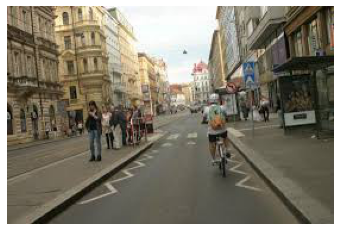

In [86]:
image = load_img(os.getcwd() + '/images/train/neutral/image_104.jpg')
plt.imshow(image)
plt.axis('off')


In [141]:
validation_data_dir = os.getcwd() + '/images/test'
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

val_generator_resnet = test_datagen.flow_from_directory(
    validation_data_dir,
    batch_size=32,
    target_size=(224,224),
    classes=['fire', 'neutral','smoke'],
    class_mode='categorical'
)
val_generator_xception = test_datagen.flow_from_directory(
    validation_data_dir,
    batch_size=32,
    target_size=(299, 299),
    classes=['fire', 'neutral','smoke'],
    class_mode='categorical'
)
train_generator_restnet = train_datagen.flow_from_directory(
        # np.expand_dims(img_to_array(load_img('./images/fire_images/fire.662.png')), axis=0),
        train_images_path,
        target_size=(224, 224),
        batch_size=32, 
        # save_to_dir='./images/augmented_images', 
        # save_prefix='keras_',
        # save_format='png',
        classes=['fire', 'neutral','smoke'],
        class_mode='categorical'
)

train_generator_xception = train_datagen.flow_from_directory(
        # np.expand_dims(img_to_array(load_img('./images/fire_images/fire.662.png')), axis=0),
        train_images_path,
        target_size=(299, 299),
        batch_size=32, 
        # save_to_dir='./images/augmented_images', 
        # save_prefix='keras_',
        # save_format='png',
        classes=['fire', 'neutral','smoke'],
        class_mode='categorical'
)


Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 2700 images belonging to 3 classes.
Found 2700 images belonging to 3 classes.


(32, 224, 224, 3)
[1. 0. 0.]


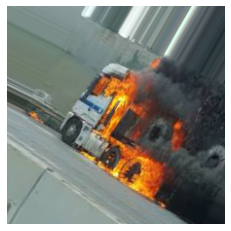

(32, 224, 224, 3)
[0. 1. 0.]


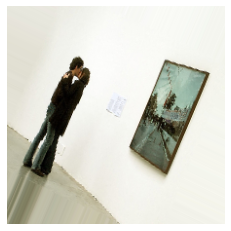

(32, 224, 224, 3)
[1. 0. 0.]


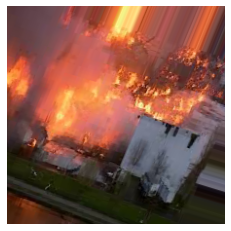

(32, 224, 224, 3)
[0. 0. 1.]


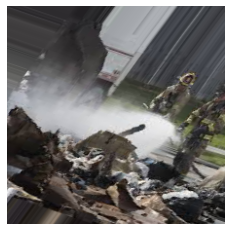

(32, 224, 224, 3)
[0. 1. 0.]


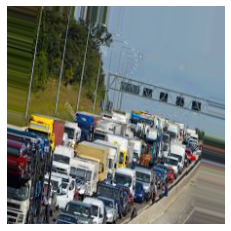

(32, 224, 224, 3)
[1. 0. 0.]


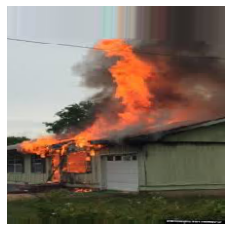

(32, 224, 224, 3)
[1. 0. 0.]


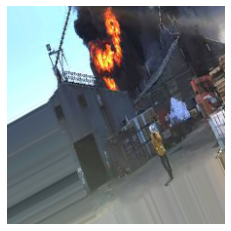

(32, 224, 224, 3)
[0. 1. 0.]


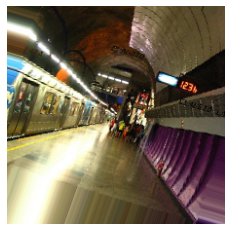

(32, 224, 224, 3)
[1. 0. 0.]


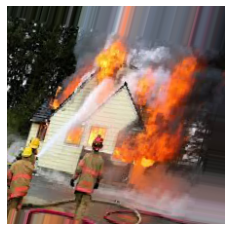

(32, 224, 224, 3)
[0. 1. 0.]


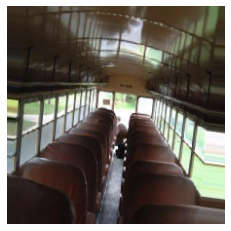

In [131]:
count = 0
for x, y in train_generator_restnet:
    count += 1
    if (count > 10):
        break
    print(x.shape)

    print(y[0])
    img = x[0]
    plt.imshow(img)
    plt.axis('off')
    # plt.title('Class: [{},{}]'.format(y[0], y[1]) )
    plt.show()

In [144]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

#Instantiate pre-trained models for feature extraction and classification
#Models list.
    #Resnet50: Size=98MB, TOP-1 Accuracy=0.749, # Parameters=25,636,712, inpuit_dim=(224,224)
    #Xception: Size=88MB, TOP-1 Accuracy=0.790, # Parameters=22,910,480, input_dim=(299,299)
rn_base = ResNet50(weights='imagenet')
xc_base = Xception(weights='imagenet')

for layer in rn_base.layers:
    layer.trainable=False
for layer in xc_base.layers:
    layer.trainable=False    
NUM_CLASSES = 3
#Select last hidden layer's output
sec_last_base_rs = rn_base.layers[-2].output
sec_last_base_xc = xc_base.layers[-2].output

x_rn = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(sec_last_base_rs)
x_rn = Activation('relu')(x_rn)
x_rn = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x_rn)
x_rn = Activation('relu')(x_rn)
rn_connected_model = Dense(NUM_CLASSES, activation='softmax')(x_rn)

x_xc = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(sec_last_base_xc)
x_xc = Activation('relu')(x_xc)
x_xc = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x_xc)
x_xc = Activation('relu')(x_xc)
xc_connected_model = Dense(NUM_CLASSES, activation='softmax')(x_xc)

#Get the model's input tensor
base_input_rs = rn_base.input
base_input_xc = xc_base.input
#Assemble the final model
rn_model = Model(inputs=base_input_rs, outputs=rn_connected_model)
xc_model = Model(inputs=base_input_xc, outputs=xc_connected_model)
#Compile models
rn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#%%
#Construct the callback functions
early_stop = EarlyStopping(monitor='val_loss', patience=9, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, min_delta=1e-4)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5'),
model_checkpoint_xc = tf.keras.callbacks.ModelCheckpoint(filepath='XceptionModel/model.{epoch:02d}-{val_loss:.2f}.h5'),
callbacks_list = [early_stop, reduce_lr, model_checkpoint]
callbacks_list_xc = [early_stop, reduce_lr, model_checkpoint_xc]

In [138]:
#Train resnet model
N_EPOCHS = 10
STEPS_PER_EPOCH = train_generator_restnet.n // train_generator_restnet.batch_size

start = timeit.timeit()
print('[INFO] Training Model Resnet.. \n')
rn_history = rn_model.fit(train_,
                                    validation_data=val_generator_xception,  
                                    validation_steps=val_generator_xception.n//32,
                                    epochs=N_EPOCHS,
                                    steps_per_epoch=STEPS_PER_EPOCH,
                                    callbacks=callbacks_list)
print('[INFOR] Resnet model training finished. \n')
end = time.time()
print('Time elapesed: ', end-start)

[INFO] Training Model Resnet.. 

Epoch 1/10
84/84 [==============================] - 41s 492ms/step - loss: 146.1408 - accuracy: 0.4048 - val_loss: 6.6222 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/10
84/84 [==============================] - 41s 487ms/step - loss: 4.7311 - accuracy: 0.3265 - val_loss: 4.2871 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 3/10
84/84 [==============================] - 40s 481ms/step - loss: 4.2078 - accuracy: 0.3242 - val_loss: 4.2052 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 4/10
84/84 [==============================] - 41s 483ms/step - loss: 4.1655 - accuracy: 0.3295 - val_loss: 4.1406 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 5/10
84/84 [==============================] - 41s 484ms/step - loss: 4.1380 - accuracy: 0.3182 - val_loss: 4.1209 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 6/10
84/84 [==============================] - 41s 489ms/step - loss: 4.1201 - accuracy: 0.3246 - val_loss: 4.1202 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 7/10
84/84 [===========

In [145]:
start = time.time()
print('[INFO] Training Model Xception.. \n')
xc_history = xc_model.fit(train_generator_xception,
                          validation_data=val_generator_xception,  
                          validation_steps=val_generator_xception.n//32,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          epochs=N_EPOCHS,
                          callbacks=callbacks_list_xc)
print('[INFOR] Xception model training finished. \n')
end = time.time()
print('Time elapesed: ', end-start)


[INFO] Training Model Xception.. 

Epoch 1/10
84/84 [==============================] - 66s 787ms/step - loss: 140.5057 - accuracy: 0.4648 - val_loss: 5.6504 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 2/10
84/84 [==============================] - 66s 782ms/step - loss: 4.3402 - accuracy: 0.3306 - val_loss: 4.0242 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 3/10
84/84 [==============================] - 66s 782ms/step - loss: 3.9678 - accuracy: 0.3298 - val_loss: 3.9301 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 4/10
84/84 [==============================] - 66s 785ms/step - loss: 3.9116 - accuracy: 0.3388 - val_loss: 3.9007 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 5/10
84/84 [==============================] - 66s 785ms/step - loss: 3.8910 - accuracy: 0.3193 - val_loss: 3.8846 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/10
84/84 [==============================] - 65s 774ms/step - loss: 3.8777 - accuracy: 0.3283 - val_loss: 3.8717 - val_accuracy: 0.3229 - lr: 0.0010
Epoch 7/10
84/84 [=========

<Figure size 360x360 with 0 Axes>

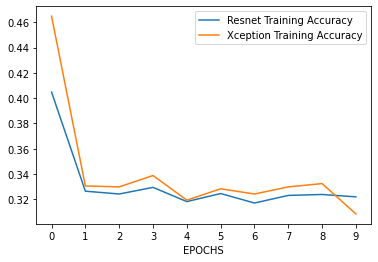

In [149]:
def plot_train_accuracy(histories, model_names):
  plt.figure(figsize=(5,5))
  fig,ax = plt.subplots()
  for history, m_name in zip(histories, model_names):
    hor_axis = np.arange(0, len(history.history['accuracy']))
    plt.plot(hor_axis, history.history['accuracy'], label='{} Training Accuracy'.format(m_name))
    plt.xlabel('EPOCHS')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(0, len(history.history['accuracy']), 1))
    plt.legend()
  plt.show()

# print('Resnet Training Accuracy: ', rn_history.history['accuracy'][-1])
plot_train_accuracy([rn_history, xc_history], ['Resnet', 'Xception'])

